# Motions with visous damping from Ikeda (Cutting)

# Purpose
Motions simulation were conducted with visous damping from Ikeda.
Now cut the signals when the memory effect is destroying the measurement.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')
from reports.paper_writing import save_fig

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from copy import deepcopy
import joblib
from rolldecayestimators import measure
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify

## Load data from Motions:

In [3]:
file_paths = [
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large2',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large_5deg',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large_ikeda',
]
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
df_parameters

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg
kvlcc2_rolldecay_15-5kn_const_large,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.7,-5.0,0.7,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.7,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large_5deg,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large_ikeda,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735


In [122]:
time_series = helpers.load_time_series(df_parameters=df_parameters)
time_series_raw = deepcopy(time_series)

for key,df in time_series.items():
    
    if df.mean().abs()['V1'] > 0.01:
        #X = preprocess.remove_acceleration_part(df=df, q=0.99, steady_ratio=0.01)
        
        phi1d_limit = 10**-2
        index0 = (df['phi1d'].abs() > phi1d_limit).argmax()
        X = df.iloc[index0:].copy()
        #mask = X.index < 110
        #X = X.loc[mask].copy()
        
        time_series[key] = X
        
X = time_series['kvlcc2_rolldecay_15-5kn_const_large_ikeda']
time_series['kvlcc2_rolldecay_15-5kn_const_large_ikeda'] = X.loc[0:45]

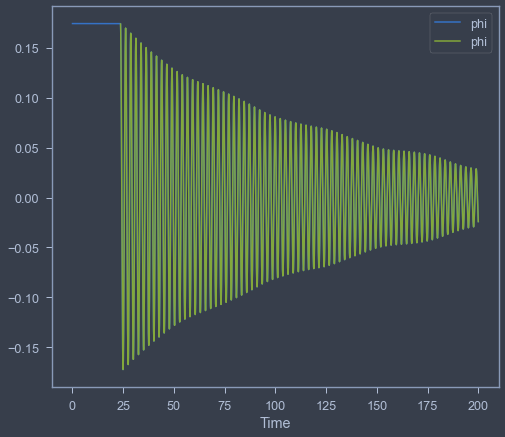

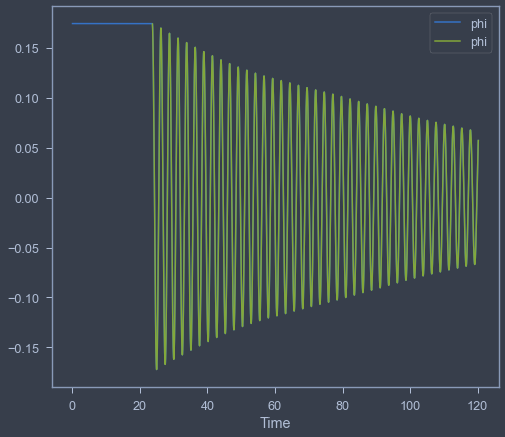

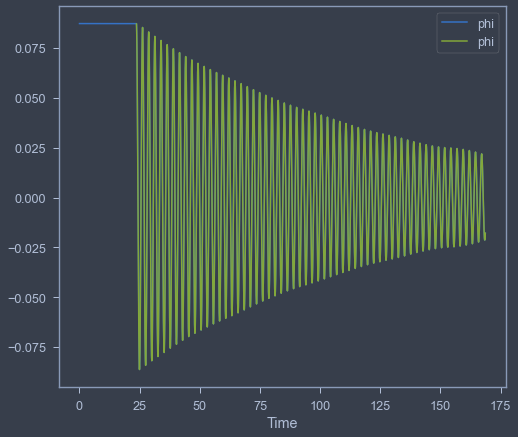

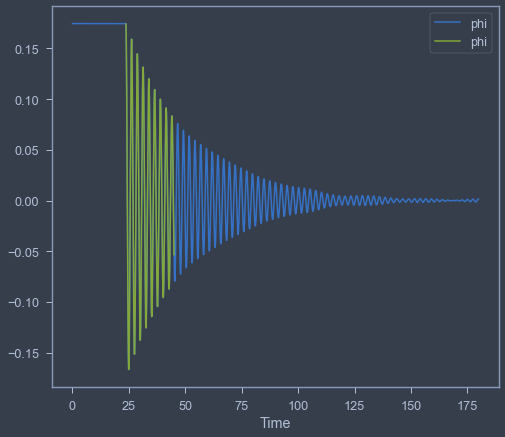

In [123]:
for key, df in time_series.items():
    
    fig,ax = plt.subplots()
    time_series_raw[key].plot(y='phi', ax=ax)
    df.plot(y='phi', ax=ax)

In [125]:
X = time_series['kvlcc2_rolldecay_15-5kn_const_large_ikeda']
pre_model= EstimatorQuadraticB(fit_method='derivation')
pre_model.fit(X)

model_motions = EstimatorQuadraticB(p0=pre_model.parameters)
model_motions.fit(X)

In [126]:
## MDL:
pipeline_mdl = joblib.load('../models/KVLCC2_speed.pkl')
model_mdl = pipeline_mdl['estimator']

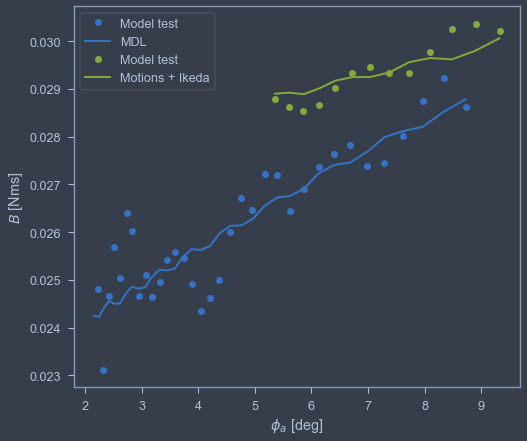

In [127]:
fig,ax=plt.subplots()

model_mdl.plot_damping(ax=ax, label='MDL')
model_motions.plot_damping(ax=ax, label='Motions + Ikeda')

<AxesSubplot:xlabel='time'>

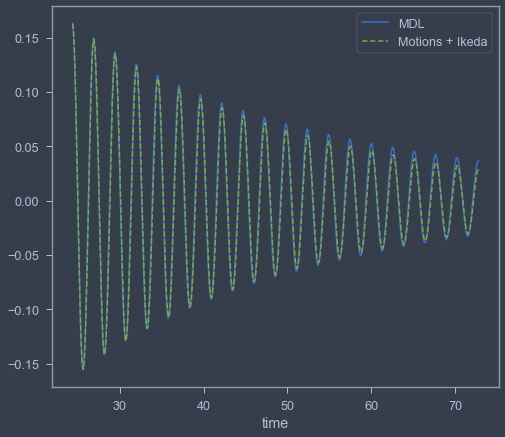

In [128]:
df_motions = model_motions.predict(model_mdl.X)

fig,ax=plt.subplots()
model_mdl.X.plot(y='phi', label='MDL', ax=ax)
df_motions.plot(y='phi', style='--', label='Motions + Ikeda', ax=ax)


<AxesSubplot:>

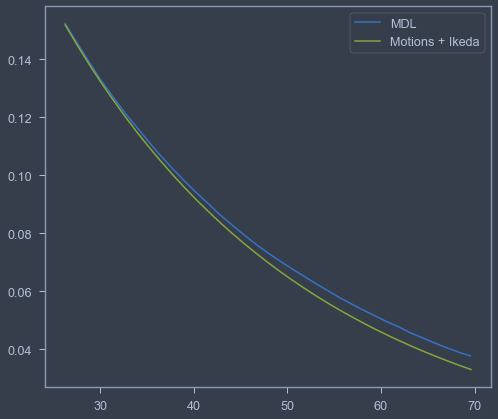

In [129]:
fig,ax=plt.subplots()


df_amplitude_MDL = measure.calculate_amplitudes_and_damping(X=model_mdl.X)
df_amplitude_motions = measure.calculate_amplitudes_and_damping(X=df_motions)

df_amplitude_MDL.plot(y='phi_a', label='MDL', ax=ax)
df_amplitude_motions.plot(y='phi_a', label='Motions + Ikeda', ax=ax)

In [130]:
parameters = df_parameters.iloc[0]
scale_factor = 68
GM = 5.737/scale_factor

meta_data={
    'Volume' : parameters.V,
    'rho' : parameters.dens,
    'g' : parameters.gravi,
    'GM' : GM,
    
}
results = model_motions.result_for_database(meta_data=meta_data)
results

{'C_1A': 6.0811926683186615,
 'B_2A': 0.020321720808588916,
 'B_1A': 0.06709224867556936,
 'score': 0.999503105292228,
 'phi_start': 0.17409050747039037,
 'phi_stop': -0.053499919165944404,
 'omega0_fft': 2.469291825721843,
 'A_44': 135.10054407704789,
 'C_1': 821.572438127206,
 'B_2': 2.74547553782223,
 'B_1': 9.06419929942202,
 'omega0': 2.466007434765488}

In [131]:
df_amplitude_motions = measure.calculate_amplitudes_and_damping(X=model_motions.X)

df_amplitude_motions['B_model'] = lambdas.B_e_lambda(B_1=results['B_1'], B_2=results['B_2'], omega0=results['omega0'], phi_a=df_amplitude_motions['phi_a'])
df_amplitude_motions['B_model']=df_amplitude_motions['B_model'].astype(float)

df_amplitude_motions['B_ikeda'] = lambdas.B_e_lambda(B_1=parameters['b4l'], B_2=parameters['b4q'], omega0=results['omega0'], phi_a=df_amplitude_motions['phi_a'])
df_amplitude_motions['B_ikeda']=df_amplitude_motions['B_ikeda'].astype(float)

B_W_1 = results['B_1'] - parameters['b4l']
B_W_2 = results['B_2'] - parameters['b4q']
df_amplitude_motions['B_W'] = lambdas.B_e_lambda(B_1=B_W_1, B_2=B_W_2, omega0=results['omega0'], phi_a=df_amplitude_motions['phi_a'])
df_amplitude_motions['B_W']=df_amplitude_motions['B_W'].astype(float)

df_amplitude_motions['B_'] = df_amplitude_motions['B_W'] + df_amplitude_motions['B_ikeda']

<AxesSubplot:xlabel='phi_a'>

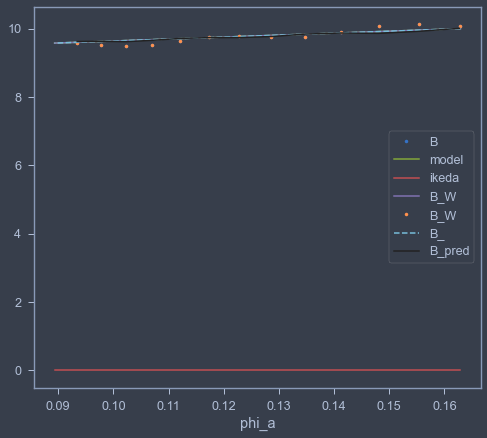

In [132]:
A_44 = 135.00020704200577
#omega = 2.4675051745904346
omega = df_amplitude_motions['omega0']
df_amplitude_motions['B'] = df_amplitude_motions['zeta_n']*A_44*2*omega
df_amplitude_motions['B_W_'] = df_amplitude_motions['B'] - df_amplitude_motions['B_ikeda']


fig,ax=plt.subplots()
df_amplitude_motions.plot(x='phi_a', y='B', style='.', ax=ax)
df_amplitude_motions.plot(x='phi_a', y='B_model', label='model', ax=ax)
df_amplitude_motions.plot(x='phi_a', y='B_ikeda', label='ikeda', ax=ax)
df_amplitude_motions.plot(x='phi_a', y='B_W', label='B_W', ax=ax)
df_amplitude_motions.plot(x='phi_a', y='B_W_', label='B_W', style='.', ax=ax)

df_amplitude_motions.plot(x='phi_a', y='B_', style='--', label='B_', ax=ax)


df_amplitude_motions_pred = measure.calculate_amplitudes_and_damping(X=model_motions.predict(X=model_motions.X))
omega = df_amplitude_motions_pred['omega0']
df_amplitude_motions_pred['B'] = df_amplitude_motions_pred['zeta_n']*A_44*2*omega

df_amplitude_motions_pred.plot(x='phi_a', y='B', style='-', label='B_pred', ax=ax)

<AxesSubplot:xlabel='phi_a'>

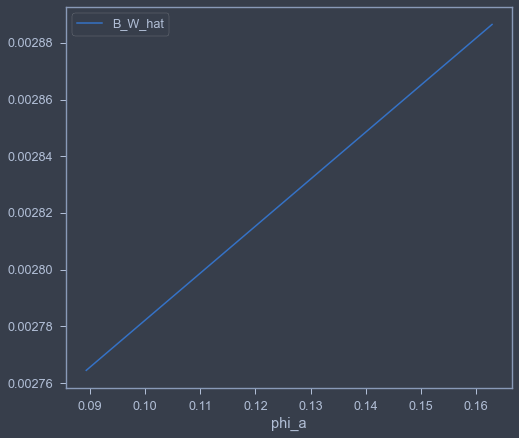

In [133]:
df_hat = hatify(df=df_amplitude_motions[['B_W']], Disp=meta_data['Volume'], beam=parameters.B, g=meta_data['g'], rho=meta_data['rho'])
df_hat['phi_a'] = df_amplitude_motions['phi_a']
df_hat.plot(x='phi_a', y='B_W_hat')

## Comparing with the Motions results without viscous damping

In [135]:
motion_models = {}

for motions_file_path,X in time_series.items():
        
    parameters = df_parameters.loc[motions_file_path]
        
    pre_model = EstimatorQuadraticB(fit_method='derivation')
    pre_model.fit(X=X)
    model = EstimatorQuadraticB(fit_method='integration', p0=pre_model.parameters)
        
    try:
        model.fit(X=X)
    except scipy.linalg.LinAlgError:
        model.fit(X=X)  # Retry
    
    if pre_model.score() > model.score():
        model = pre_model
    
    motion_models[motions_file_path] = model

In [136]:
df_amplitudes = pd.DataFrame()

for motions_file_path, model in motion_models.items():
    
    amplitudes = measure.calculate_amplitudes_and_damping(X=model.X)
        
    omega = amplitudes['omega0']
    amplitudes['B'] = amplitudes['zeta_n']*A_44*2*omega
    amplitudes['name'] = motions_file_path
    
    df_amplitudes = df_amplitudes.append(amplitudes, ignore_index=True)
    

In [137]:
runs = df_amplitudes.groupby(by='name')
amplitudes = runs.get_group('kvlcc2_rolldecay_15-5kn_const_large_ikeda')
B_ikeda = lambdas.B_e_lambda(B_1=parameters['b4l'], B_2=parameters['b4q'], omega0=results['omega0'], phi_a=amplitudes['phi_a'])
df_amplitudes.loc[amplitudes.index,'B']=amplitudes['B']-B_ikeda

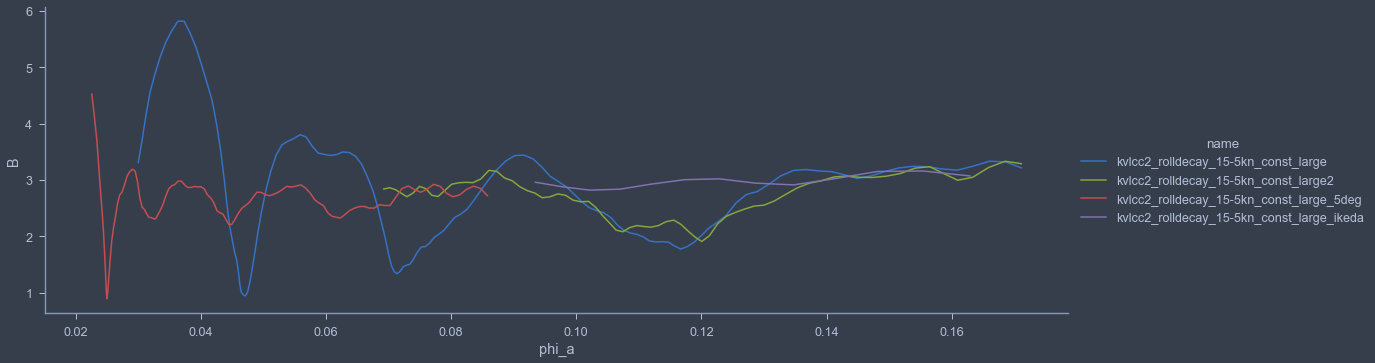

In [138]:
import seaborn as sns

sns.relplot(data=df_amplitudes, x='phi_a', y='B', kind='line', hue='name', height=5, aspect=3)